# Neurale Netwerken

## Inleiding

Het concept van Neurale Netwerken is eenvoudig in de simpelste vorm, maar heel complex in zijn meest ingewikkelde vorm. 

## Uitwerking

In deze notebook wordt met behulp van een van Kaggle verkregen dataset een uitwerking van Neurale Netwerken
uitgevoerd. De uitwerking wordt vergeleken met die van de naive methodiek om te toetsen hoe goed het model is. Met
behulp van andere meetmethodes wordt de accuraatheid van het model onderzocht. 

### Dataset
We gaan een dataset van een voorgaande uitwerking, die van Logistische Regressie, opnieuw gebruiken. Dit is de Pokémon dataset. Op deze manier kunnen we de uitslagen van het Neurale Netwerk vergelijken met die van Logistische Regressie.

Link naar dataset: https://www.kaggle.com/abcsds/pokemon/downloads/pokemon.zip/2

### Doelstelling

Met deze dataset willen we een simpele vraag beantwoorden:
> "<i>Afhankelijk van de stats van een pokémon, kan die pokémon als legendary worden geclassificeerd?"</i>

Er zijn ook andere velden zoals de eerste en mogelijke tweede type van een pokémon. Deze worden echter niet meegenomen omdat niet alle pokemon een tweede type hebben, dit kan voor problemen in het model zorgen. 

### Filteren van de data
Zoals er in de vorige paragraaf is gezegd, wordt er alleen gekeken naar de volgende statistieken van de Pokémon:

1. Totale stats
2. Attack
3. Defense
4. Sp. Atk (Special attack)
5. Sp. Def (Special defense)
6. Speed
7. Wel <i>of</i> niet legendary

Allereerst de import en daarna de uitwerking van een Neuraal Netwerk.

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
data = pd.read_csv('data/pokemon.csv')
data_indexed = data.set_index('Name')
data_sorted = data.sort_values('Total')
data_filterd = data_sorted.filter(['Total', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary'])

##### Splitsen van data

Nu de data uit het csv-bestand is gehaald kan de data gesplitst worden in X en y zoals te zien was in het voorbeeld. Deze X en y data kunnen we vervolgens in trainings en test data splitsen om het model te trainen en te testen.

In [3]:
data_X = data_filterd.copy()
data_y = pd.DataFrame(data_X.pop('Legendary'))
data_y.head()

,Legendary
206,False
322,False
446,False
288,False
16,False


In [4]:
data_X.head()

,Total,Attack,Defense,Sp. Atk,Sp. Def,Speed
206,180,30,30,30,30,30
322,190,20,40,20,40,20
446,194,25,41,25,41,25
288,195,45,35,20,30,20
16,195,35,30,20,20,50


## Bouwen, trainen en testen van een Neuraal Netwerk

### Aanmaken van het model

Voor het aanmaken en trainen van het model wordt gebruikt gemaakt van de TensorFlow library. Deze library is gekozen vanwege de uitgebreide documentatie en omdat het zeer beginners-vriendelijk is. Het uiteindelijke model zal waarschijnlijk niet veel prestatie hebben, maar wel simpel genoeg zijn om te begrijpen en dus om te programmeren.

Om de data te laten inlezen in het model moeten alle stats van de pokémon tussen de 0 en 1 worden geschaald. Hierbij wordt een stat geschaald op de grootste waarde van de feature.

Om te beginnen wordt er een input layer van 6 nodes, een voor iedere stat, aangemaakt. Hierna volgen 6^2 = 36 nodes in de tweede layer. Dit is voor mogelijke stat combinaties die verbintenis met elkaar hebben; een langzame pokemon heeft vaak ook een hoge defense of sp. def. Vervolgens is de output layer een enkele node voor legendary of niet legendary.

De activatie functie van iedere laag is gebaseerd op de beginners recommedaties in de 'Train your first Neural Network' handleiding van Tensorflow organisatie.

link: https://www.tensorflow.org/tutorials/keras/basic_classification

In [5]:
from tensorflow import keras

# negeren van een warning, dit is een bug in tensorflow
import logging
logging.getLogger('tensorflow').disabled = True

# aanmaken van het model
model = keras.Sequential([
    keras.layers.Dense(6, activation=tf.nn.softplus),
    keras.layers.Dense(18, activation=tf.nn.relu),
    keras.layers.Dense(18, activation=tf.nn.sigmoid),
    keras.layers.Dense(1, activation=tf.nn.softplus)
])

### Compileren van het model

Voordat het model kan worden getraind moeten enkele instellingen worden gekozen. Dit zijn de loss-functie, de optimalisatie-functie en welke metrieken (metrics) we willen meten tijdens het trainen.

De loss-function van mean_absolute_error is gekozen voor zijn effectiviteit in het identificeren van legendary pokémon en omdat het geschaald is tussen de 1 en 0 vanwege de genormaliseerde data. Het normaliseren wordt in de volgende paragraaf gedaan.

In [6]:
loss_function = keras.losses.mean_absolute_error

model.compile(optimizer='adam', 
              loss=loss_function,
              metrics=['accuracy'])

Uitleg per functie:

* De optimalisatie-functie is de manier waarop het model de gewichten aanpast en dus leert. Hierbij wordt ook de loss-functie gebruikt
* De loss-functie meet hoeveel verlies het model heeft, we willen dus dat de waarde van deze functie een minimum heeft.
* We willen de accuracy bijhouden van de pokemon die goed zijn voorspeld.

### Trainen van het model

Nu het model gemaakt is moeten we alleen nog de trainings en test data normaliseren tussen 0 en 1. Dit is in de tweede alinea van het 'Aanmaken van het model' kopje besproken.

In [7]:
data_y_normalised = data_y.copy()
data_y_normalised['Legendary'] *= 1

data_X_normalised = pd.DataFrame()
for stat in list(data_X):
    data_X_normalised[stat] = data_X[stat] / data_X[stat].max()

#### Opsplitsen in train en test data
Nu de X en y data is gesplitst en genormaliseerd kunnen we de trainingsdata ervan maken via train_test_split() functie van sci-kit-learn. Deze wordt geimporteerd en toegepast op de X en y data. Hier komen vier variabelen uit:
- Test en trainings data voor X
- Test en trainings data voor y

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X_normalised, data_y_normalised, test_size=0.40)

#### Trainen

De data is gereed en het model is aangemaakt en gecompileerd. Nu alleen nog het model trainen. Er is gekozen voor 5 epochs, als er meer nodig zijn wordt dit aantal verhoogd. Na iedere epoch wordt de accuraatheid van het model getoond. Zodra de accuraatheid constant op 1 is is er last van overfitting.

In [9]:
history = model.fit(X_train.values,
                    y_train.values.ravel(),
                    epochs=20, batch_size=4,
                    validation_data=(X_test.values, y_test.values.ravel())
                   )
print()
model.summary()

Train on 480 samples, validate on 320 samples
Epoch 1/20
480/480 [==============================] - 0s 821us/sample - loss: 0.4220 - acc: 0.6500 - val_loss: 0.2021 - val_acc: 0.9094
Epoch 2/20
480/480 [==============================] - 0s 347us/sample - loss: 0.1367 - acc: 0.9250 - val_loss: 0.1245 - val_acc: 0.9094
Epoch 3/20
480/480 [==============================] - 0s 392us/sample - loss: 0.1008 - acc: 0.9250 - val_loss: 0.1096 - val_acc: 0.9094
Epoch 4/20
480/480 [==============================] - 0s 489us/sample - loss: 0.0912 - acc: 0.9250 - val_loss: 0.1038 - val_acc: 0.9094
Epoch 5/20
480/480 [==============================] - 0s 473us/sample - loss: 0.0868 - acc: 0.9250 - val_loss: 0.1007 - val_acc: 0.9094
Epoch 6/20
480/480 [==============================] - 0s 417us/sample - loss: 0.0843 - acc: 0.9250 - val_loss: 0.0987 - val_acc: 0.9094
Epoch 7/20
480/480 [==============================] - 0s 360us/sample - loss: 0.0826 - acc: 0.9250 - val_loss: 0.0973 - val_acc: 0.9094
Ep

### plotten van de historie

Om een goed inzicht te krijgen in de historie van de accuracy worden deze gegevens geplot.

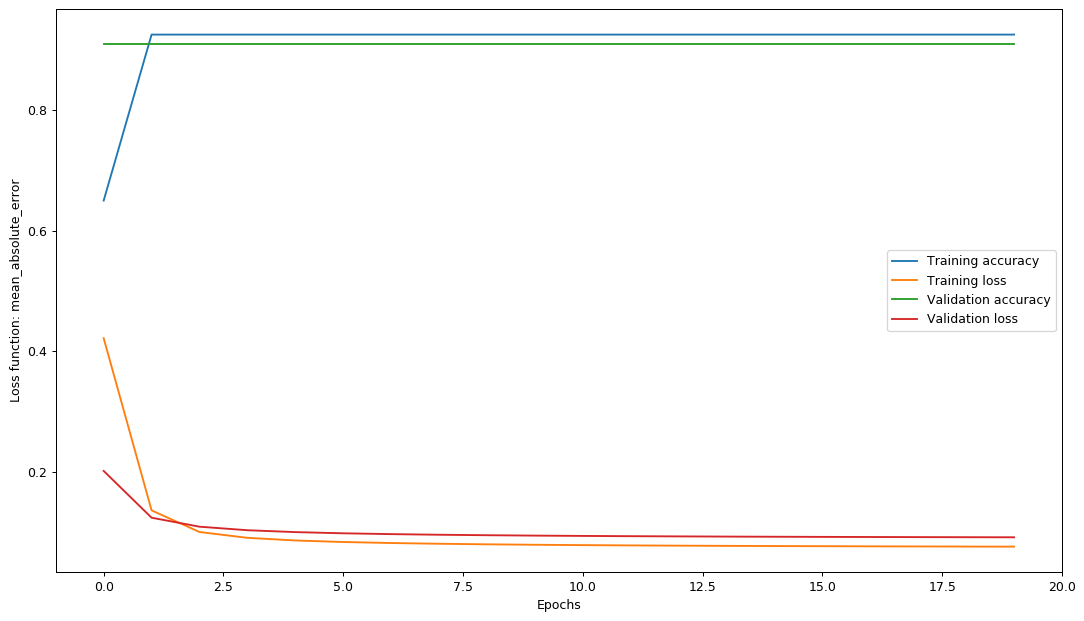

In [10]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.figure(dpi=90, figsize=(12,7))
plt.plot(np.arange(len(history.history['acc'])), history.history['acc'], label='Training accuracy')
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], label='Training loss')
plt.plot(np.arange(len(history.history['val_acc'])), history.history['val_acc'], label='Validation accuracy')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel(f'Loss function: {loss_function.__name__}')
plt.legend()
plt.tight_layout()
plt.xlim([-1,max(history.epoch)+1])
plt.savefig(f'./epochs_model_{loss_function.__name__}')

#### Evaluatie plot

Zoals te zien is gaat de accuracy van het model zeer snel omhoog, dit komt waarschijnlijk door de relatieve kleine dataset. Voor het gebruik van een Neuraal Netwerk zit je vaak aan de 100.000 samples te denken. Gezien er maar 800 pokemon records zijn in de database is dit dus een kleine dataset. Bij Logisitsche Regressie was ook al gekeken naar de dataset en was er een hoge correlatie tussen de stats of deze pokémon een legendary is.

## Overfitting en underfitting

*uitleg overfitting en underfitting*

Een model kan teveel op de trainingsdata lijken waardoor het bij de validatie een slechtere accuracy heeft. Dit is slecht en je hebt dus een slecht model. Underfitting is niet het tegenovergesteld, maar dat je te weinig data hebt om een model te trainen voor wat je wilt voorspellen. Dit zorgt dus voor een model wat slecht blijft voorspellen.

*kans op underfitting door kleine data*

Omdat onze dataset relatief klein is, bestaat er een kans dat ons model underfit is en niet goed kan valideren.

### Verschillende nodes
Om te zien hoe het model reageert met verschillende aantal nodes worden twee nieuwe modellen gemaakt:
    
1. 2 layers met ieder 2 nodes.
2. 2 layers met ieder 32 nodes.

We evalueren met verschillende nodes om te kijken of er overfitting en underfitting optreedt en hoe we dit kunnen identificeren.

In [11]:
# klein model met twee kleine hidden layers met ieder 2 nodes
model_klein = keras.Sequential([
    keras.layers.Dense(6, activation=tf.nn.softplus),
    keras.layers.Dense(2, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.sigmoid),
    keras.layers.Dense(1, activation=tf.nn.softplus)
])

# groot model met twee groten hidden layers met ieder 32 nodes
model_groot = keras.Sequential([
    keras.layers.Dense(6, activation=tf.nn.softplus),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.sigmoid),
    keras.layers.Dense(1, activation=tf.nn.softplus)
])

modellen = [model_klein, model_groot]

### compileren van het model

Voor ieder model gaan we dezelfde loss en optimalisatie functie gebruiken en de accuracy meten.

In [12]:
# loss_function in cell 6 gedefinieerd.
for m in modellen:
    m.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

### Trainen van de nieuwe modellen

De modellen zijn aangemaakt een gecompileerd, de trainingsdata is bij het eerste model al vastgelegd.

In [13]:
histories = []

for m in modellen:
    histories.append(
        m.fit(
            X_train.values,
            y_train.values.ravel(),
            epochs=20,
            batch_size=4,
            validation_data=(X_test.values, y_test.values.ravel())
        )
    )

Train on 480 samples, validate on 320 samples
Epoch 1/20
480/480 [==============================] - 0s 636us/sample - loss: 0.7922 - acc: 0.0750 - val_loss: 0.6533 - val_acc: 0.0906
Epoch 2/20
480/480 [==============================] - 0s 361us/sample - loss: 0.5612 - acc: 0.1896 - val_loss: 0.4862 - val_acc: 0.7875
Epoch 3/20
480/480 [==============================] - 0s 418us/sample - loss: 0.4373 - acc: 0.9167 - val_loss: 0.4027 - val_acc: 0.9094
Epoch 4/20
480/480 [==============================] - 0s 423us/sample - loss: 0.3696 - acc: 0.9250 - val_loss: 0.3503 - val_acc: 0.9094
Epoch 5/20
480/480 [==============================] - 0s 368us/sample - loss: 0.3234 - acc: 0.9250 - val_loss: 0.3116 - val_acc: 0.9094
Epoch 6/20
480/480 [==============================] - 0s 361us/sample - loss: 0.2882 - acc: 0.9250 - val_loss: 0.2815 - val_acc: 0.9094
Epoch 7/20
480/480 [==============================] - 0s 350us/sample - loss: 0.2600 - acc: 0.9250 - val_loss: 0.2570 - val_acc: 0.9094
Ep

In [14]:
# voeg allereerste model en historie ook toe aan de lijsten
modellen.append(model)
histories.append(history)

#### plotten van de histories

Om de cijfer hierboven te verduidelijken wordt de data in twee grafieken geplot. Bovenste voor de validatie (testdata) en de onderste voor de training (traingsdata).

<Figure size 1440x810 with 0 Axes>

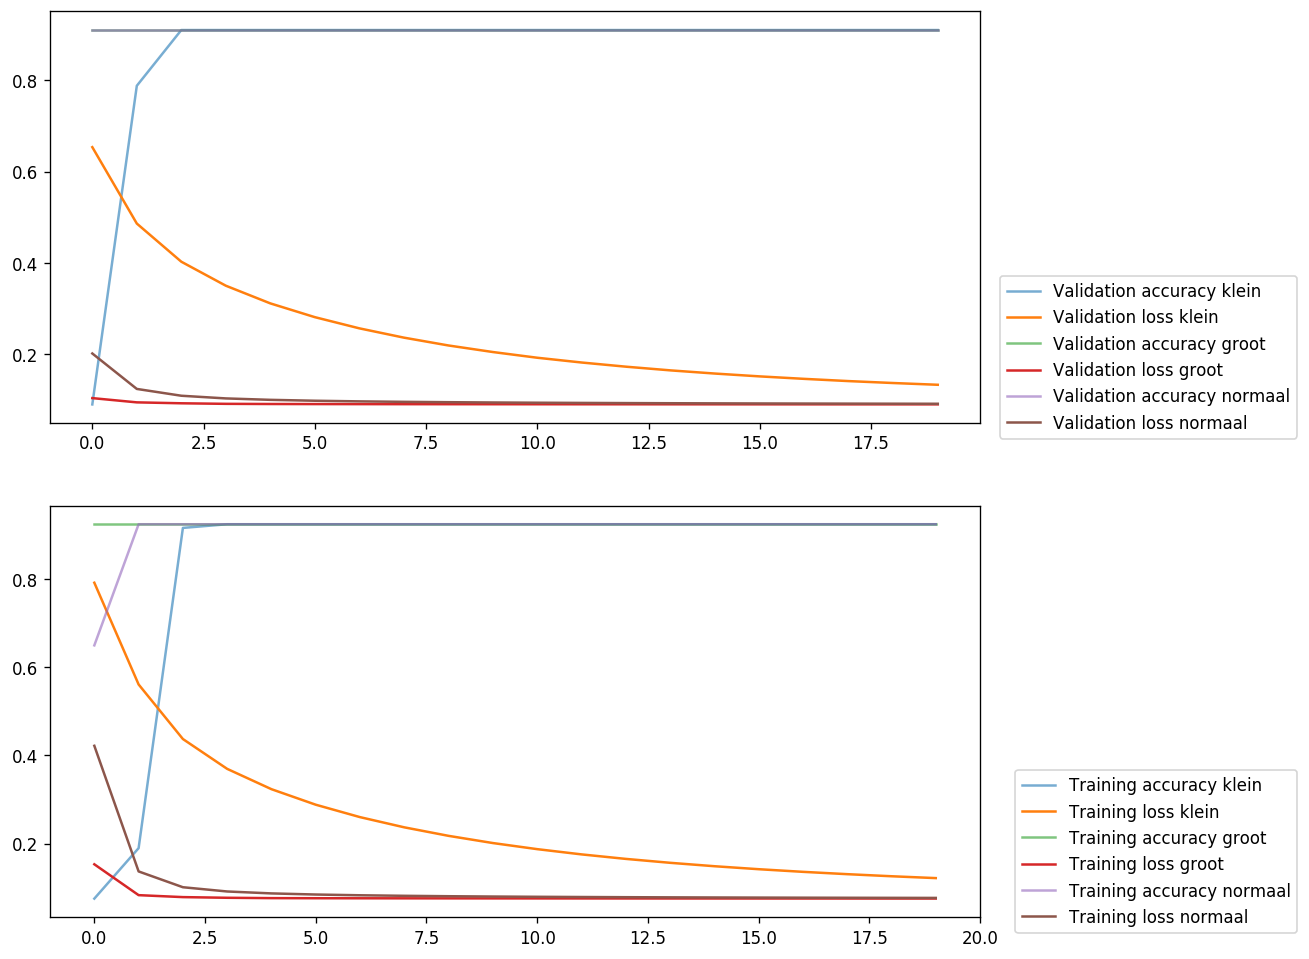

In [15]:
plt.figure(1, dpi=90, figsize=(16,9))
names = ['klein', 'groot', 'normaal']

# subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), dpi=120)

# counter voor benaming
i = 0

for h, m in zip(histories, modellen):
    ax1.plot(np.arange(len(h.history['val_acc'])),  h.history['val_acc'], alpha=0.6, label=f'Validation accuracy {names[i]}')
    ax1.plot(np.arange(len(h.history['val_loss'])), h.history['val_loss'], label=f'Validation loss {names[i]}')
    ax1.legend(bbox_to_anchor=(1.35, 0.16), loc=5)

    
    i += 1

i = 0
    
for h, m in zip(histories, modellen):
    ax2.plot(np.arange(len(h.history['acc'])), h.history['acc'], alpha=0.6, label=f'Training accuracy {names[i]}')
    ax2.plot(np.arange(len(h.history['loss'])), h.history['loss'], label=f'Training loss {names[i]}')
    ax2.legend(bbox_to_anchor=(1.35, 0.16), loc=5)
    
    i += 1

plt.xlim([-1,max(history.epoch)+1])
plt.savefig(f'./epochs_model_{loss_function.__name__}')

#### Evaluatie plots

Zoals te zien is de accuracy van het kleine model langzamer omhoog en is de loss vrijblijvend hoog. Als dit model verder getraind wordt dan kan de accuracy omhoog gaan omdat de los bijft dalen. Dit is een geval van underfitting omdat de loss blijft dalen.

In tegendeel is te zien dat het grote model sneller leert dan het eerste normale model. Gezien de dataset relatief klein is er geen overfitting opgetreden. 

# Conclusie

Het resultaat van de modellen, behalve die van de kleine, zijn duidelijk. Een Neuraal Netwerk (NN) is een goeie methode om een legendary pokemon te voorspellen. Het is echter minder accuraat dan Logistiche Regressie die vaak tussen de 94% en 97% zat met de accuraatheid vergeleken de 91% van het NN.

NN zou een betere methode zijn wanneer er veel meer data is om mee te werken. Bij de dataset zijn de verbintenissen tussen de data vrij duidelijk als je veel pokémon spellen hebt gespeeld. De legendary pokémon zijn vaker sterker dan andere pokémon. NN zou dus een betere methode zijn om connecties tussen data te vinden waarbij de verbintenissen onduidelijker zijn.